In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
class DQNExperiments:
    BATCH_SIZE = 128
    GAMMA = 0.99
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 1000
    TAU = 0.005
    LR = 1e-4
    NUM_EPISODES = 600
    steps_done = 0

    def run_experiment(self, env):
        env = env
        n_actions = env.action_space.n
        state, info = env.reset()
        n_observations = len(state)

        policy_net = DQN(n_observations, n_actions).to(device)
        target_net = DQN(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())

        optimizer = optim.AdamW(policy_net.parameters(), lr=self.LR, amsgrad=True)
        memory = ReplayMemory(10000)

        self.steps_done = 0

        def select_action(state):
            sample = random.random()
            eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                math.exp(-1. * self.steps_done / self.EPS_DECAY)
            self.steps_done += 1
            if sample > eps_threshold:
                with torch.no_grad():
                    return policy_net(state).max(1).indices.view(1, 1)
            else:
                return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


        episode_durations = []


        def plot_durations(show_result=False):
            plt.figure(1)
            durations_t = torch.tensor(episode_durations, dtype=torch.float)
            if show_result:
                plt.title('Result')
            else:
                plt.clf()
                plt.title('Training...')
            plt.xlabel('Episode')
            plt.ylabel('Duration')
            plt.plot(durations_t.numpy())
            # Take 100 episode averages and plot them too
            if len(durations_t) >= 100:
                means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
                means = torch.cat((torch.zeros(99), means))
                plt.plot(means.numpy())

            plt.pause(0.001)  # pause a bit so that plots are updated
            if is_ipython:
                if not show_result:
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                else:
                    display.display(plt.gcf())

        def optimize_model():
            if len(memory) < self.BATCH_SIZE:
                return
            transitions = memory.sample(self.BATCH_SIZE)
            batch = Transition(*zip(*transitions))

            # Compute a mask of non-final states and concatenate the batch elements
            # (a final state would've been the one after which simulation ended)
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
            # columns of actions taken. These are the actions which would've been taken
            # for each batch state according to policy_net
            state_action_values = policy_net(state_batch).gather(1, action_batch)

            # Compute V(s_{t+1}) for all next states.
            # Expected values of actions for non_final_next_states are computed based
            # on the "older" target_net; selecting their best reward with max(1).values
            # This is merged based on the mask, such that we'll have either the expected
            # state value or 0 in case the state was final.
            next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
            with torch.no_grad():
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
            # Compute the expected Q values
            expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

            # Compute Huber loss
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()
        
        for i_episode in range(self.NUM_EPISODES):
            # Initialize the environment and get its state
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                action = select_action(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                # Store the transition in memory
                memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                optimize_model()

                # Soft update of the target network's weights
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                target_net.load_state_dict(target_net_state_dict)

                if done:
                    episode_durations.append(t + 1)
                    plot_durations()
                    break

        print('Complete')
        plot_durations(show_result=True)
        plt.ioff()
        plt.show()

        return episode_durations

In [8]:
all_trainings = []
for _ in range(10):
    exp = DQNExperiments()
    all_trainings.append(exp.run_experiment(env))

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [1]:
import gymnasium as gym
import numpy as np

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

env = gym.make("Pendulum-v1", render_mode="rgb_array")

# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=30000, log_interval=10)
model.save("td3_pendulum")
vec_env = model.get_env()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.55e+03 |
| time/              |           |
|    episodes        | 10        |
|    fps             | 120       |
|    time_elapsed    | 16        |
|    total_timesteps | 2000      |
| train/             |           |
|    actor_loss      | 39.1      |
|    critic_loss     | 0.0245    |
|    learning_rate   | 0.001     |
|    n_updates       | 1899      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.35e+03 |
| time/              |           |
|    episodes        | 20        |
|    fps             | 122       |
|    time_elapsed    | 32        |
|    total_timesteps | 4000      |
| train/             |           |
|    actor_loss      | 64.7   

In [ ]:
import matplotlib.pyplot as plt

while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    # print(action, rewards)
    clear_output(wait=True)
    plt.imshow( vec_env.render(mode='rgb_array') )
    plt.show()

: 

In [21]:
! pip3 install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.6 MB/s eta 0:00:0000:0100:01


In [1]:
%load_ext autoreload
%autoreload 2

Episode 0, Reward: 14.0, Epsilon: 0.99
Episode 1, Reward: 18.0, Epsilon: 0.99
Episode 2, Reward: 11.0, Epsilon: 0.99
Episode 3, Reward: 21.0, Epsilon: 0.98
Episode 4, Reward: 18.0, Epsilon: 0.98
Episode 4, Eval return: 11.00
Episode 5, Reward: 15.0, Epsilon: 0.97
Episode 6, Reward: 15.0, Epsilon: 0.97
Episode 7, Reward: 19.0, Epsilon: 0.96
Episode 8, Reward: 19.0, Epsilon: 0.96
Episode 9, Reward: 11.0, Epsilon: 0.95
Episode 9, Eval return: 10.00
Episode 10, Reward: 40.0, Epsilon: 0.95
Episode 11, Reward: 23.0, Epsilon: 0.94
Episode 12, Reward: 13.0, Epsilon: 0.94
Episode 13, Reward: 22.0, Epsilon: 0.93
Episode 14, Reward: 11.0, Epsilon: 0.93
Episode 14, Eval return: 11.00
Episode 15, Reward: 24.0, Epsilon: 0.92
Episode 16, Reward: 16.0, Epsilon: 0.92
Episode 17, Reward: 32.0, Epsilon: 0.91
Episode 18, Reward: 21.0, Epsilon: 0.91
Episode 19, Reward: 40.0, Epsilon: 0.90
Episode 19, Eval return: 13.00
Episode 20, Reward: 35.0, Epsilon: 0.90
Episode 21, Reward: 17.0, Epsilon: 0.90
Episode 

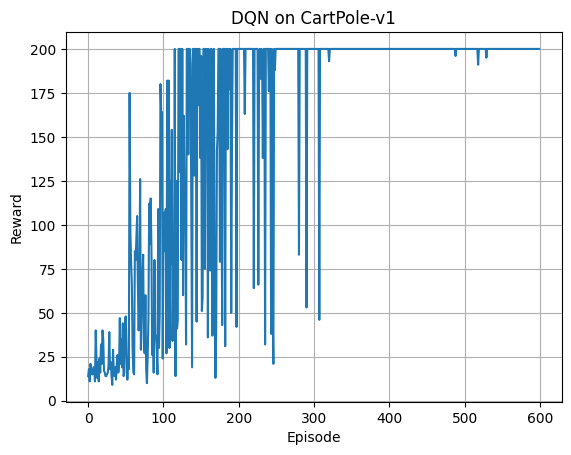

([14.0,
  18.0,
  11.0,
  21.0,
  18.0,
  15.0,
  15.0,
  19.0,
  19.0,
  11.0,
  40.0,
  23.0,
  13.0,
  22.0,
  11.0,
  24.0,
  16.0,
  32.0,
  21.0,
  40.0,
  35.0,
  17.0,
  16.0,
  14.0,
  14.0,
  15.0,
  16.0,
  20.0,
  39.0,
  18.0,
  22.0,
  14.0,
  9.0,
  29.0,
  16.0,
  14.0,
  19.0,
  12.0,
  21.0,
  26.0,
  16.0,
  20.0,
  47.0,
  21.0,
  35.0,
  19.0,
  44.0,
  14.0,
  16.0,
  47.0,
  48.0,
  28.0,
  12.0,
  24.0,
  18.0,
  175.0,
  97.0,
  79.0,
  66.0,
  29.0,
  16.0,
  15.0,
  85.0,
  80.0,
  92.0,
  105.0,
  65.0,
  40.0,
  59.0,
  126.0,
  29.0,
  51.0,
  69.0,
  83.0,
  33.0,
  27.0,
  60.0,
  18.0,
  10.0,
  25.0,
  46.0,
  112.0,
  89.0,
  115.0,
  87.0,
  26.0,
  49.0,
  16.0,
  80.0,
  36.0,
  37.0,
  29.0,
  15.0,
  109.0,
  30.0,
  49.0,
  180.0,
  164.0,
  164.0,
  24.0,
  92.0,
  107.0,
  85.0,
  109.0,
  27.0,
  182.0,
  52.0,
  182.0,
  30.0,
  125.0,
  78.0,
  154.0,
  34.0,
  70.0,
  51.0,
  200.0,
  14.0,
  125.0,
  41.0,
  46.0,
  200.0,
  200.0,
  130.

In [2]:
from dqn import DQNAgent
import gymnasium as gym
from utils import ReplayBuffer

agent = DQNAgent(
    env_name="CartPole-v1"
)

agent.train_with_seed(0)

Episode 0, Return: -1803.18
Episode 1, Return: -1319.80
Episode 2, Return: -1585.68
Episode 3, Return: -1528.31
Episode 4, Return: -1800.14
Episode 4, Eval return: -1823.64
Episode 5, Return: -1694.32
Episode 6, Return: -1831.50
Episode 7, Return: -1779.03
Episode 8, Return: -1860.72
Episode 9, Return: -1617.54
Episode 9, Eval return: -1548.38
Episode 10, Return: -1821.81
Episode 11, Return: -1607.18
Episode 12, Return: -1575.53
Episode 13, Return: -1744.12
Episode 14, Return: -1250.56
Episode 14, Eval return: -863.83
Episode 15, Return: -1518.80
Episode 16, Return: -1026.17
Episode 17, Return: -1047.06
Episode 18, Return: -1289.88
Episode 19, Return: -1343.33
Episode 19, Eval return: -1496.93
Episode 20, Return: -1197.25
Episode 21, Return: -1306.85
Episode 22, Return: -1184.08
Episode 23, Return: -1054.28
Episode 24, Return: -1241.22
Episode 24, Eval return: -1075.40
Episode 25, Return: -1513.58
Episode 26, Return: -1098.03
Episode 27, Return: -1179.35
Episode 28, Return: -952.91
Epi

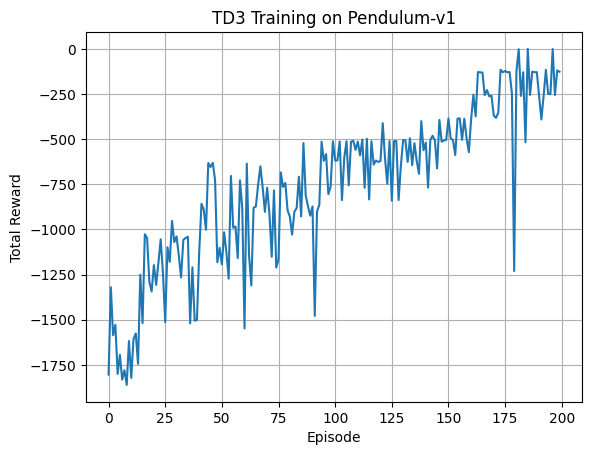

([np.float64(-1803.1762222703244),
  np.float64(-1319.798254468781),
  np.float64(-1585.678859339496),
  np.float64(-1528.305700860771),
  np.float64(-1800.1358903306282),
  np.float64(-1694.3237145064115),
  np.float64(-1831.4979551728602),
  np.float64(-1779.0314851426567),
  np.float64(-1860.7150563009911),
  np.float64(-1617.5381089530883),
  np.float64(-1821.8050936403058),
  np.float64(-1607.1761923071156),
  np.float64(-1575.5331445229133),
  np.float64(-1744.1227845408164),
  np.float64(-1250.5625624582433),
  np.float64(-1518.7979277590985),
  np.float64(-1026.1738318534526),
  np.float64(-1047.0648522346253),
  np.float64(-1289.8751813745528),
  np.float64(-1343.3276951339328),
  np.float64(-1197.250262824238),
  np.float64(-1306.84984684376),
  np.float64(-1184.0759315337548),
  np.float64(-1054.284952955148),
  np.float64(-1241.2206773243843),
  np.float64(-1513.583656088678),
  np.float64(-1098.0252538319896),
  np.float64(-1179.345637808812),
  np.float64(-952.90809280887

In [13]:
from td3 import TD3

agent = TD3(env_name="Pendulum-v1", hidden_dim=256, num_layers=3, episodes=200)
agent.train_with_seed(0)